# Draft `pyGIMLi(emg3d)`

**NEEDS**
- `pyGIMLi`
- `emg3d`
- `discretize`
- `xarray`
- `h5py`


An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.

For developing purposes, we take a very simple grid/model/survey:
- Coarse mesh, no stretching (potentially too small).
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 5 sources (3 in the coarse one), 1 frequency.

=> For this dev-implementation we also do inversion crime, using the same grid for forward modelling and inversion.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm


In [22]:
import emg3d

## Coarse-flag
- Coarse model: 3 src, 57 rec, 1 freq; 32 x 16 x 16 = 8,192 cells 
- Fine model: 5 src, 57 rec, 1 freq; 64 x 32 x 32 = 65,536 cells

In [23]:
coarse = True
#coarse = False

## Create a survey

In [24]:
azimuth = 0.0
elevation = 0.0

# Receiver line
rec_x = np.arange(-7000, 7001, 250.)
rec_y = 0.0
rec_z = 0.0
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (rec_x, rec_y, rec_z, azimuth, elevation)
)

# Sources
if coarse:
    src_x = np.array([-5000, 0.0, 5000])
    src_y = 250.0
else:
    src_x = np.array([-5000, -2500, 0.0, 2500, 5000])
    src_y = 125.0
src_z = 50.0
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (src_x, src_y, src_z, azimuth, elevation),
        strength=1000,
)

frequencies = np.array([1.0, ])

survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=frequencies,
    noise_floor=1e-17,
    relative_error=0.05,
)

# QC
survey

:: Survey ::

<xarray.Dataset>
Dimensions:   (src: 3, rec: 57, freq: 1)
Coordinates:
  * src       (src) <U6 'TxED-1' 'TxED-2' 'TxED-3'
  * rec       (rec) <U7 'RxEP-01' 'RxEP-02' 'RxEP-03' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 (nan+nanj) (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-17
    relative_error:  0.05

## Create a simple model

In [25]:
if coarse:
    hx = np.ones(32)*500.0
    hyz = np.ones(16)*500.0
else:
    hx = np.ones(64)*250.0
    hyz = np.ones(32)*250.0
grid = emg3d.TensorMesh([hx, hyz, hyz], [-8125, -4000, -4000])

# QC
grid

TensorMesh: 8,192 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     32     -8,125.00      7,875.00    500.00    500.00    1.00
   y     16     -4,000.00      4,000.00    500.00    500.00    1.00
   z     16     -4,000.00      4,000.00    500.00    500.00    1.00

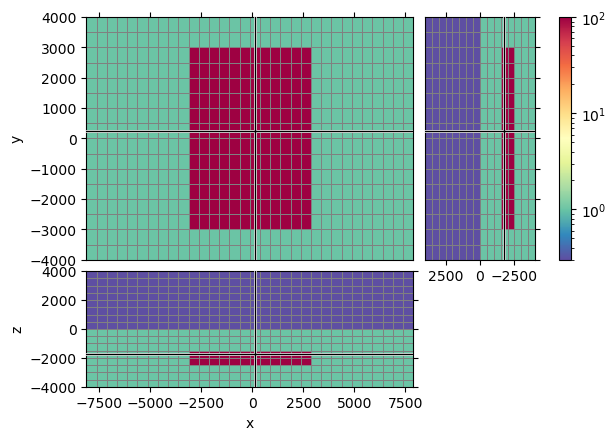

Model: resistivity; isotropic; 32 x 16 x 16 (8,192)

In [26]:
# Initial model
model = emg3d.Model(grid, 1.0)
if coarse:
    model.property_x[:, :, 8:] = 0.3
else:
    model.property_x[:, :, 16:] = 0.3

# Model with a target
tg_model = model.copy()
if coarse:
    tg_model.property_x[10:-10, 2:-2, 3:5] = 100.0
else:
    tg_model.property_x[22:-22, 5:-5, 8:10] = 100.0

# QC, in resistivity (Ohm.m)
popts = {'edgecolors': 'grey', 'linewidth': 0.5,
         'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
grid.plot_3d_slicer(tg_model.property_x, pcolor_opts=popts, zslice=-1900)

if 0:
    # Plot survey in figure above
    fig = plt.gcf()
    fig.suptitle('Resistivity model (Ohm.m) and survey layout')
    axs = fig.get_children()
    rec_coords = survey.receiver_coordinates()
    src_coords = survey.source_coordinates()
    axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
    axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
    axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
    axs[1].plot(src_coords[0], src_coords[1], 'r*')
    axs[2].plot(src_coords[0], src_coords[2], 'r*')
    axs[3].plot(src_coords[2], src_coords[1], 'r*')
    plt.show()

# QC
tg_model

## Generate synthetic data

In [27]:
simulation = emg3d.simulations.Simulation(
    survey=survey,
    model=tg_model,
    gridding='same',
    max_workers=6,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    # solver_opts,
)

# Let's QC our Simulation instance
simulation

:: Simulation ::

- Survey: 3 sources; 57 receivers; 1 frequencies
- Model: resistivity; isotropic; 32 x 16 x 16 (8,192)
- Gridding: Same grid as for model; 32 x 16 x 16 (8,192)

In [28]:
simulation.compute(observed=True, min_offset=1000)
del survey.data['synthetic']  # Observed (with noise) remains stored

Compute efields            0/3  [00:00]

In [29]:
if coarse:
    emg3d.save('pginv-coarse.h5', model=model, survey=survey, true_model=tg_model)
else:
    emg3d.save('pginv.h5', model=model, survey=survey, true_model=tg_model)

Data saved to «c:\Guenther.T\src\gimli\dev-pygimli-emg3d\pginv-coarse.h5»
[emg3d vunknown-20231214 (format 1.0) on 2023-12-14T12:36:23.717607].


## QC initial model

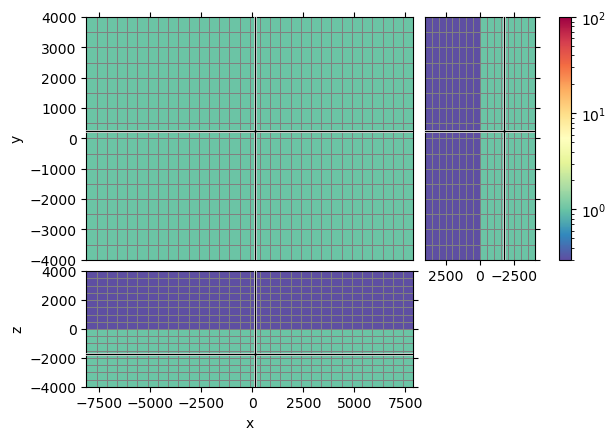

In [30]:
grid.plot_3d_slicer(model.property_x, pcolor_opts=popts, zslice=-1900)
if 0:
    # Plot survey in figure above
    fig = plt.gcf()
    fig.suptitle('Initial resistivity model (Ohm.m) and survey layout')
    axs = fig.get_children()
    axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
    axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
    axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
    axs[1].plot(src_coords[0], src_coords[1], 'r*')
    axs[2].plot(src_coords[0], src_coords[2], 'r*')
    axs[3].plot(src_coords[2], src_coords[1], 'r*')
    plt.show()

## Compute responses for initial model, QC that the data is sensitive to the target

In [31]:
init_sim = emg3d.simulations.Simulation(
    survey=survey,
    model=model,
    gridding='same',
    max_workers=6,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    # solver_opts,
)

init_sim.compute()

Compute efields            0/3  [00:00]

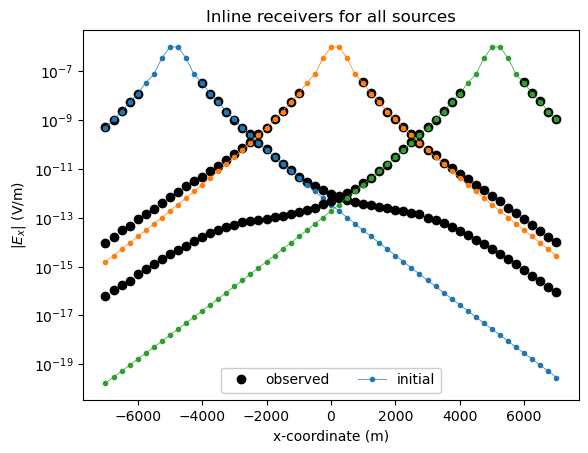

In [32]:
plt.figure()
plt.title("Inline receivers for all sources")
obs = init_sim.data.observed
syn = init_sim.data.synthetic
rec_coords = survey.receiver_coordinates()

for i, src in enumerate(survey.sources.keys()):
    plt.plot(rec_coords[0], abs(obs.loc[src, :, :].data), "ko", label='observed' if i == 0 else '')
    plt.plot(rec_coords[0], abs(syn.loc[src, :, :].data), f"C{i}.-", lw=0.5, label='initial' if i == 0 else '')

plt.yscale('log')
plt.legend(ncol=2, framealpha=1)
plt.xlabel('x-coordinate (m)')
plt.ylabel('$|E_x|$ (V/m)')
plt.show()

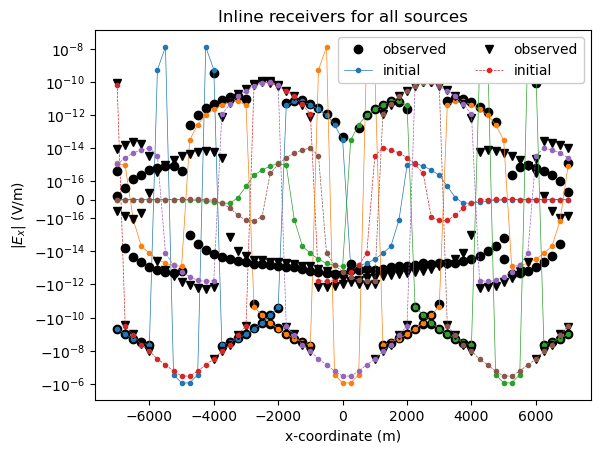

In [33]:
plt.figure()
plt.title("Inline receivers for all sources")
obs = init_sim.data.observed
syn = init_sim.data.synthetic
rec_coords = survey.receiver_coordinates()

for i, src in enumerate(survey.sources.keys()):
    plt.plot(rec_coords[0], (obs.loc[src, :, :].data.real), "ko", label='observed' if i == 0 else '')
    plt.plot(rec_coords[0], (syn.loc[src, :, :].data.real), f"C{i}.-", lw=0.5, label='initial' if i == 0 else '')
    plt.plot(rec_coords[0], (obs.loc[src, :, :].data.imag), "kv", label='observed' if i == 0 else '')
    plt.plot(rec_coords[0], (syn.loc[src, :, :].data.imag), f"C{i+3}.--", lw=0.5, label='initial' if i == 0 else '')

plt.yscale('symlog', linthresh=1e-16)
plt.legend(ncol=2, framealpha=1)
plt.xlabel('x-coordinate (m)')
plt.ylabel('$|E_x|$ (V/m)')
plt.show()

In [34]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Thu Dec 14 12:36:28 2023 Mitteleuropäische Zeit

                OS : Windows
            CPU(s) : 20
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC
  v.1929 64 bit (AMD64)]

             numpy : 1.21.6
             scipy : 1.10.1
             numba : 0.57.1
             emg3d : unknown-20231214
           empymod : 2.2.2
            xarray : 2023.5.0
        discretize : 0.9.0
              h5py : 3.9.0
        matplotlib : 3.7.1
              tqdm : 4.65.0
           IPython : 8.12.0
--------------------------------------------------------------------------------